In [57]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import scipy
import h5py
import sklearn.datasets 

In [2]:
import import_ipynb
from Normalization import Normalizer
from ActivationFunctions import ActivationFunctions
from LossFunctions import LossFunctions

importing Jupyter notebook from Normalization.ipynb
importing Jupyter notebook from ActivationFunctions.ipynb
importing Jupyter notebook from LossFunctions.ipynb


In [86]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    X = X.T
    Y = Y.T

    return X, Y

def load_extra_datasets():  
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)

    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c = y[0], cmap=plt.cm.Spectral)

In [78]:
class ShallowNeuralNetwork():
    activationFunctions = ActivationFunctions()
    normalizer = Normalizer()
    lossFunctions = LossFunctions()
    default_threshold = 0.5
    parameters = {}
    
    def _layer_sizes(self, X, Y, hidden_size = 4):
        """
        """
        n_x = X.shape[0] # size of input layer
        n_h = hidden_size
        n_y = Y.shape[0] # size of output layer
        return (n_x, n_h, n_y)
    
    def _initialize_parameters(self, n_x, n_h, n_y, seed = 2):
        """
        Initialize weights randomly
        """
        np.random.seed(seed) # we set up a seed so that your output matches ours although the initialization is random.

        W1 = np.random.randn(n_h,n_x) * 0.01
        b1 = np.zeros((n_h, 1))
        W2 = np.random.randn(n_y, n_h) * 0.01
        b2 = np.zeros((n_y, 1))

        parameters = {"W1": W1,
                      "b1": b1,
                      "W2": W2,
                      "b2": b2}
        return parameters
    
    def _forward_propagation(self, X, parameters, activation_function_h = "tanh"):
        """
        Forward Propagation
        """
        # Forward Propagation to calculate A2 (probabilities)
        Z1 = np.dot(parameters["W1"] , X) + parameters["b1"]
        if activation_function_h == "tanh" : A1 = np.tanh(Z1)
        Z2 = np.dot(parameters["W2"] , A1) + parameters["b2"]
        A2 = activationFunctions.sigmoid(Z2)

        cache = {"Z1": Z1,
                 "A1": A1,
                 "Z2": Z2,
                 "A2": A2}

        return A2, cache

    def _compute_cost(self, A2, Y, parameters):
        """
        Computes the cross-entropy cost

        """
        m = Y.shape[1]

        # Compute the cross-entropy cost
        logprobs = np.multiply(np.log(A2),Y) + np.multiply((1 - Y), np.log(1 - A2))
        cost = - (1 / m) * np.sum(logprobs)

        cost = float(np.squeeze(cost)) 

        return cost
    
    def _backward_propagation(self, parameters, cache, X, Y, activation_function_h = "tanh"):
        """
        Implement the backward propagation using the instructions above.
        """
        m = X.shape[1]

        # First, retrieve W1 and W2 from the dictionary "parameters".
        W1 = parameters["W1"]
        W2 = parameters["W2"]

        # Retrieve also A1 and A2 from dictionary "cache".
        A1 = cache["A1"]
        A2 = cache["A2"]

        # Backward propagation: calculate dW1, db1, dW2, db2. 
        dZ2 = A2 - Y
        dW2 = (1 / m) * np.dot(dZ2 , A1.T)
        db2 = (1 / m) * np.sum(dZ2, axis = 1, keepdims=True)
        if activation_function_h == "tanh" : dZ1 = W2.T * dZ2 * (1 - np.power(A1, 2))
        dW1 = (1 / m) * np.dot(dZ1 , X.T)
        db1 = (1 / m) * np.sum(dZ1, axis = 1, keepdims=True)

        grads = {"dW1": dW1,
                 "db1": db1,
                 "dW2": dW2,
                 "db2": db2}

        return grads
    
    def _update_parameters(self, parameters, grads, learning_rate = 1.2):
        """
        Updates parameters using the gradient descent update rule given above
        """
        W1 = parameters["W1"] - learning_rate * grads["dW1"]
        b1 = parameters["b1"] - learning_rate * grads["db1"]
        W2 = parameters["W2"] - learning_rate * grads["dW2"]
        b2 = parameters["b2"] - learning_rate * grads["db2"]

        parameters = {"W1": W1,
                      "b1": b1,
                      "W2": W2,
                      "b2": b2}

        return parameters
    
    def train(self, X, Y, n_h, num_iterations = 10000, activation_functions_per_layer = ["tanh", "sigmoid"],
              learning_rate = 1.2, print_cost=False):
        """
        Training a neural network with 1 hidden layer with 4 neurons
        """

        np.random.seed(3)
        n_x = layer_sizes(X, Y)[0]
        n_y = layer_sizes(X, Y)[2]

        # Initialize parameters
        parameters = self._initialize_parameters(n_x, 4, n_y)

        # Loop (gradient descent)

        for i in range(0, num_iterations):

            # Forward propagation
            A2, cache = self._forward_propagation(X, parameters, activation_function_h=activation_functions_per_layer[0])

            # Cost function
            cost = self._compute_cost(A2, Y, parameters)

            # Backpropagation
            grads = self._backward_propagation(parameters, cache, X, Y, activation_function_h=activation_functions_per_layer[0])

            # Gradient descent parameter update
            parameters = self._update_parameters(parameters, grads, learning_rate)

            if print_cost and i % 1000 == 0:
                print ("Cost after iteration %i: %f" %(i, cost))

        self.parameters = parameters
    
    def predict(self, X, threshold = default_threshold):
        """
        Using the learned parameters, predicts a class for each example in X
        """
        # Computes probabilities using forward propagation, and classifies to 0/1 using threshold
        A2, cache = self._forward_propagation(X, self.parameters)
        predictions = np.where(A2 > threshold, 1, 0)

        return predictions

In [87]:
shallowNeuralnetwork = ShallowNeuralNetwork()

X, Y = load_planar_dataset()
shallowNeuralnetwork.train(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219504
Cost after iteration 9000: 0.218571


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

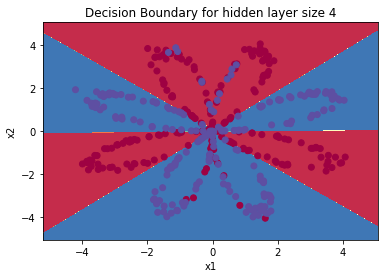

In [88]:
plot_decision_boundary(lambda x: shallowNeuralnetwork.predict(x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

Cost after iteration 0: 0.693527
Cost after iteration 1000: 0.324388
Cost after iteration 2000: 0.323299
Cost after iteration 3000: 0.323036
Cost after iteration 4000: 0.322914
Cost after iteration 5000: 0.322844
Cost after iteration 6000: 0.322799
Cost after iteration 7000: 0.322766
Cost after iteration 8000: 0.322742
Cost after iteration 9000: 0.322724


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

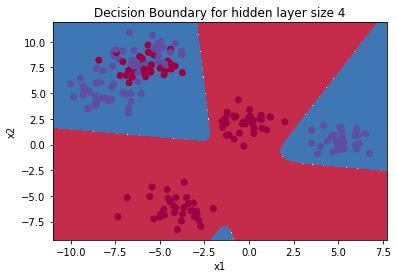

In [111]:
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

choosen_dataset = "blobs"

X_new, Y_new = datasets[choosen_dataset]
X_new, Y_new = X_new.T, Y_new.reshape(1, Y_new.shape[0])

if choosen_dataset == "blobs":
    Y_new = Y_new%2

newShallowNeuralnetwork = ShallowNeuralNetwork()
newShallowNeuralnetwork.train(X_new, Y_new, n_h = 10, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: newShallowNeuralnetwork.predict(x.T), X_new, Y_new)
plt.title("Decision Boundary for hidden layer size " + str(4))